In [87]:
%load_ext autoreload
%autoreload 2
from sound_field import sound_field
from signal_info import signal_info
from optimizer import optimizer
from DoA_est import DoA_via_bands
import utils
import numpy as np
import math
import time
import torch
import gc
import os
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import dataclasses

LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_OPT_METHOD = "GD_lagrange_multi"
SLS_OPT_METHOD = "SLS"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
torch.cuda.empty_cache()  # Free up unused memory on GPU
gc.collect()  # Clean up unused memory on CPU


# Notes:
# 1) Do we really need such a high # of iter? Maybe some windows/freqs we can stop early?
# 2) Diff # of iter in localization and sound field creation?
# 3) Add mask creatiion to class? (add mask detauils to sound_field)
# 4) Sparse Attention


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


6502

In [88]:
signals = [
    signal_info(
        name="male", signal_path=r"data/sound_files/male_speech.wav", th=90, ph=90,in_rad=False,device = DEVICE
    ),
    signal_info(
        name="female", signal_path=r"data/sound_files/female_speech.wav", th=90, ph=45,in_rad=False,device=DEVICE
    ),
]

### Encode Sound Field

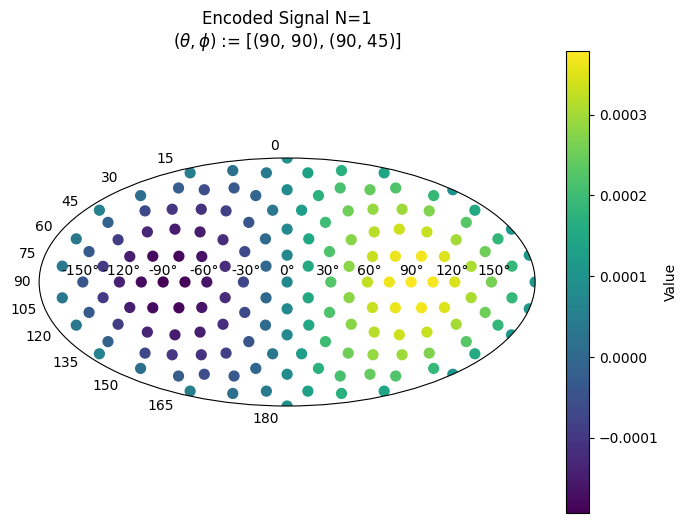

In [89]:
sound_field = sound_field(DEVICE)
input_order = 1
anm_t = sound_field.create(
    signals=signals,
    order=input_order,
    debug=True,
    grid_type=POINTS_162,
)

### Divide to Subbands

In [90]:
down_sample = 2
num_bins = 45
anm_t_subbands = sound_field.divide_to_subbands(
    num_bins=num_bins, downsample=down_sample
)
print(anm_t_subbands.shape)
print(f"{anm_t_subbands.is_cuda=}")

torch.Size([45, 68185, 4])
anm_t_subbands.is_cuda=True


### Divide to Windows

In [91]:
window_length = 1024
max_num_windows = 30
anm_t_windowed = sound_field.divide_to_time_windows(
    window_length=window_length, max_num_windows=int(max_num_windows)
)
print(anm_t_windowed.shape)
print(f"{anm_t_windowed.is_cuda=}")

torch.Size([30, 45, 1024, 4])
anm_t_windowed.is_cuda=True


### Create Mask


In [92]:
mask_type = None # "cheat" None , 'algo'

if mask_type is None:
    mask = None
    sound_field.has_mask = False
else:
    sound_field.has_mask = True
    if mask_type == "cheat":
        target_th = torch.tensor([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = torch.tensor([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = torch.any(torch.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(5),dim=1)
    elif mask_type == "algo":
        pass
    dummy = torch.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )


### Find Sparse Dict
10 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask : 1139s \
30 Windows | Lebedev | MP | 45 Freq Bands | 2 Sources | No Mask: 3496a \
10 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  33s \
30 Windows | Lebedev | MP | 1 Freq Bands | 2 Sources | No Mask:  70s 

### How its Supposed to Work

In [93]:
if False:
    Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph).to(DEVICE)
    opt = optimizer(Y_p, alpha=1, method=GD_OPT_METHOD,device=DEVICE)
    start = time.time()
    with torch.no_grad():
        anm_t_subbands_dict = sound_field.get_sparse_dict_v2(opt,mask,multi_processing=False) #single processing progress bar doesnt work
    print(f"Time: {time.time()-start}")

### Work Around

In [94]:
Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph).to(DEVICE)
opt = optimizer(Y_p, alpha=1, method=GD_OPT_METHOD,device=DEVICE)
start = time.time()
with torch.no_grad():
    Bk_matrix = sound_field.windowed_anm_t.permute(0,1,3,2) #turn to (window,band,SH_coeff,time)
    if mask is not None:
        mask_matrix = mask[None,None,...]
    else:
        mask_matrix = None
    Bk,Omega_k_opt = opt.optimize(Bk_matrix,itr = 1e5,mask = mask_matrix, D_prior = None , cheat = True)
    D_prior = None
    # sound_field.s_windowed = torch.sum(torch.tensor(sound_field.sparse_dict_subbands), axis=1)
    # sound_field.s_dict = sound_field.s_windowed.permute(1,0,2).reshape(sound_field.num_grid_points, sound_field.window_length * sound_field.num_windows)
print(f"Time: {time.time()-start}")

100%|██████████| 100000/100000 [01:48<00:00, 917.46it/s]

Finished Optimization...Stopping
Time: 110.20485472679138


In [96]:
with torch.no_grad():

    Sk = np.zeros(
        (
            sound_field.num_windows,
            sound_field.num_bins,
            sound_field.num_grid_points,
            Bk.shape[-1],
        ),
        dtype=np.float32,
    )  # (num windows,num bins,SH Coeff, Window length)

In [97]:
with torch.no_grad():
    Sk_temp, Dk = opt.unmix_and_smooth(Bk, Omega_k_opt, D_prior)


1
2
3


In [98]:
with torch.no_grad():
    print("Finished Unmixing...")
    if mask is not None:
        non_zero_indices_in_grid = torch.nonzero(mask[0, 0, :]).flatten()
        Sk[:, :, non_zero_indices_in_grid, :] = Sk_temp
    else:
        Sk = Sk_temp

        

Finished Unmixing...


In [99]:
with torch.no_grad():
    sound_field.sparse_dict_subbands = Sk
    sound_field.s_windowed = torch.sum(sound_field.sparse_dict_subbands, axis=1)
    sound_field.s_dict = sound_field.s_windowed.permute(1,0,2).reshape(sound_field.num_grid_points, sound_field.window_length * sound_field.num_windows)
    sound_field.save_sound_field('data/output')


Sound field saved to data/output\sound_field_1_order_30_win_45_bin_162_points_NOmask_24Y_11M_16F_19H_39m.pt


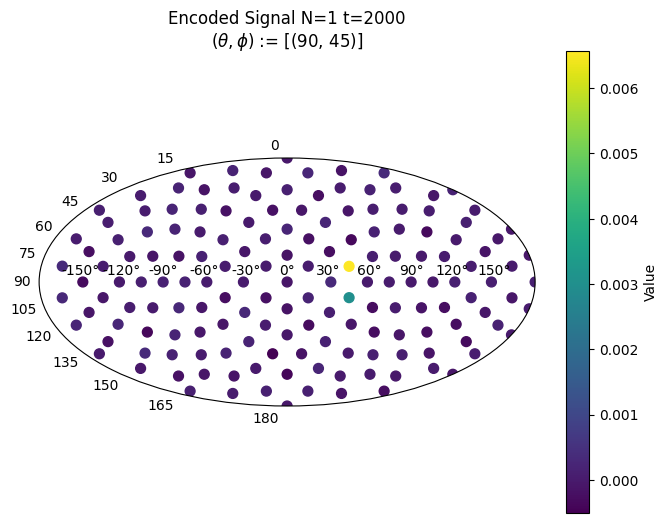

In [14]:
sound_field.plot_sparse_dict(2000)

In [ ]:
sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_162_points_NOmask_24Y_11M_16F_19H_39m.pt")

C:\Users\owner\AppData\Local\Temp\ipykernel_19316\2323324763.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sf = torch.load("data/output/sound_field_1_order_30_win_45_b

## Direction 

In [100]:
doa_estimator = DoA_via_bands(sound_field, DEVICE)

In [101]:
doa_estimator._get_window_candidates()

{0: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=570, band=np.int64(39), window=0)],
 1: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=911, band=np.int64(44), window=1)],
 2: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=930, band=np.int64(44), window=2)],
 3: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=895, band=np.int64(44), window=3)],
 4: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(31.71747441146101), count=120, band=np.int64(44), window=4)],
 5: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=963, band=np.int64(44), window=5)],
 6: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=851, band=np.int64(44), window=6)],
 7: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(90.0), count=826, band=np.int64(38), window=7)],
 8: [DoA_candidate(zen=np.float64(90.0), azi=np.float64(58.282525588538995), count=593, band=np.int64(28), window=8)],
 9: [DoA_candidate(zen=np.fl

In [102]:
def show_candidates(window_dir_candidates,window_num = None):
    if window_num is None:
        for window_num in range(len(window_dir_candidates)):
            th = window_dir_candidates[window_num][:,0].numpy()
            phi = window_dir_candidates[window_num][:,1].numpy()
            prob = window_dir_candidates[window_num][:,2].numpy()
            if len(th) == 0:
                print(f"Window {window_num} No candidates")
                continue
            plt.figure()
            plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
            plt.xlim(-180,180)
            plt.ylim(0,180)
            plt.scatter(th,phi,c=prob,cmap='viridis')
            plt.colorbar()
    else:
        plt.figure()
        plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
        plt.xlim(-180,180)
        plt.ylim(0,180)
        plt.scatter(th,phi,c=prob,cmap='viridis')
        plt.colorbar()

In [114]:
sound_field.play_sparse_sound_field(90,90)

torch.Size([162, 30720])
No directions found
